In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

from utils import *

# Introduction

Federated Learning is a rising new approach adopted by internet giants like Google and Facebook because of its nature of dealing with user privacy issue. It provided a framework for user to not sharing the private data but also be able to contribute to improve service providers’ algorithms. Such new approaches provide many opportunities but also prone to several problems such as performance issue, failure against corrupted clients and more importantly, can the federated learning really ensure user privacy? 

## Application of Federated Learning

- Healthcare -- allow sharing of sensitive patient information to train model for clinical usage.
- Finance-Technology company can train there model through decentralized datasets without worrying about privacy intrusion
- IoT devices in general  such as mobile phones are great platforms for developing federated learning scheme
 - Gboard from Google
- And all other industries that require protecting data privacy.

https://www.hitechnectar.com/blogs/applications-of-federated-learning/

## Topics to address


1. Federated Learning vs. Centralized Learning
2. Byzantine Machine and Robust methods
3. Deep Leakage from Gradients


## Data Processing for Topic 1 and 2

https://keras.io/api/datasets/mnist/

MNIST image is processed as 28 by 28 numpy arrays using grayscale. And then they are normalized by dividing 255 and flattened before training. The corresponding labels are converted into one-hot encoding before training the network model.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [4]:
x_train.shape

(60000, 28, 28, 1)

In [5]:
#flattening x_train
x_train_flattened = []
for i in range(len(x_train)):
    x_train_flattened.append(x_train[i].flatten())

x_train_flattened = np.array(x_train_flattened)

#flattening x_test
x_test_flattened = []
for i in range(len(x_test)):
    x_test_flattened.append(x_test[i].flatten())

x_test_flattened = np.array(x_test_flattened)

In [6]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test =  lb.fit_transform(y_test)

### Split Data into clients

m clients are created through random shuffling of original 60000 data points. Each client will possess 60000/m data before the training

In [21]:
clients = create_clients(x_train_flattened, y_train, num_clients=10, initial='client')

In [22]:
len(clients['client_1'])

6000

In [23]:
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((x_test_flattened, y_test)).batch(len(y_test))

Define Learning rate, communication rounds, loss function and optimizer

In [7]:
lr = 0.01 
comms_round = 50
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )           

### Model

A simple 3-layer Perception model is chosen for the task in topic1 and topic2 with the optimizer setting listed above. The model setup is adopted from this article https://towardsdatascience.com/federated-learning-a-step-by-step-implementation-in-tensorflow-aac568283399 with corresponding GitHub https://github.com/stijani/tutorial

## Topic 1: Federated vs. Centralized

#### Federated Averaging

In [24]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
  
Global_Accuracy_fa = list()
Global_LOSS_fa = list()

    
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_fa.append(global_acc)
    Global_LOSS_fa.append(global_loss)
    

comm_round: 0 | global_acc: 90.430% | global_loss: 1.6276296377182007
comm_round: 1 | global_acc: 92.020% | global_loss: 1.592659831047058
comm_round: 2 | global_acc: 93.000% | global_loss: 1.5779211521148682
comm_round: 3 | global_acc: 93.390% | global_loss: 1.5700470209121704
comm_round: 4 | global_acc: 93.990% | global_loss: 1.563595175743103
comm_round: 5 | global_acc: 94.130% | global_loss: 1.5590623617172241
comm_round: 6 | global_acc: 94.470% | global_loss: 1.5551555156707764
comm_round: 7 | global_acc: 94.610% | global_loss: 1.5519847869873047
comm_round: 8 | global_acc: 94.700% | global_loss: 1.5494141578674316
comm_round: 9 | global_acc: 94.850% | global_loss: 1.5472227334976196
comm_round: 10 | global_acc: 94.930% | global_loss: 1.545702338218689
comm_round: 11 | global_acc: 95.040% | global_loss: 1.5435588359832764
comm_round: 12 | global_acc: 95.150% | global_loss: 1.5420500040054321
comm_round: 13 | global_acc: 95.160% | global_loss: 1.54087233543396
comm_round: 14 | glob

#### Comparison to centralized learning

In [26]:
#initiate centralize learning
centralize = SimpleMLP()
centralized_model = centralize.build(784, 10)


In [27]:
centralized_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [35]:
#training
centralized_model.fit(x_train_flattened, y_train, epochs = 100, validation_split=0.1, verbose=0)

In [36]:
#testing
centralized_model.evaluate(x_test_flattened, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9765


[0.07592328637838364, 0.9764999747276306]

#### Median

In [30]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

Global_Accuracy_med = list()
Global_LOSS_med = list()

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)
    
    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_med.append(global_acc)
    Global_LOSS_med.append(global_loss)

comm_round: 0 | global_acc: 56.690% | global_loss: 2.249159336090088
comm_round: 1 | global_acc: 73.610% | global_loss: 2.159726142883301
comm_round: 2 | global_acc: 79.700% | global_loss: 2.0366897583007812
comm_round: 3 | global_acc: 82.670% | global_loss: 1.9320484399795532
comm_round: 4 | global_acc: 84.410% | global_loss: 1.8584851026535034
comm_round: 5 | global_acc: 85.530% | global_loss: 1.8076156377792358
comm_round: 6 | global_acc: 86.550% | global_loss: 1.771712064743042
comm_round: 7 | global_acc: 87.160% | global_loss: 1.7447400093078613
comm_round: 8 | global_acc: 87.690% | global_loss: 1.7244288921356201
comm_round: 9 | global_acc: 88.090% | global_loss: 1.7080107927322388
comm_round: 10 | global_acc: 88.480% | global_loss: 1.6947367191314697
comm_round: 11 | global_acc: 88.770% | global_loss: 1.6837519407272339
comm_round: 12 | global_acc: 89.040% | global_loss: 1.6748484373092651
comm_round: 13 | global_acc: 89.280% | global_loss: 1.6669453382492065
comm_round: 14 | gl

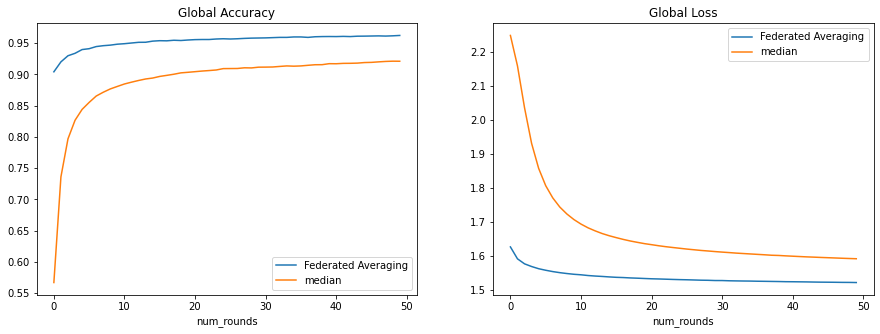

In [47]:
rounds = np.linspace(0, comms_round-1, comms_round)

fig, ax = plt.subplots(1,2, figsize = (15, 5))
ax[0].plot(rounds, Global_Accuracy_fa, label = 'Federated Averaging')
ax[0].plot(rounds, Global_Accuracy_med, label = 'median')
ax[0].set_title('Global Accuracy')
ax[0].set_xlabel('num_rounds')
ax[0].legend()
ax[1].plot(rounds, Global_LOSS_fa, label = 'Federated Averaging')
ax[1].plot(rounds, Global_LOSS_med, label = 'median')
ax[1].set_title('Global Loss')
ax[1].set_xlabel('num_rounds')
ax[1].legend()
#plt.show()
plt.savefig('fed vs med', dpi = 500, pad_inches = 0.1, bbox_inches='tight')

We can see that Average method performs much better comparing to median method when no corrupted user is at present. Within 50 rounds of communications, the global model is able to reach 96% test accruacy, which is just slightly behind a centralized setting. However, it is important to notice that it takes longer time for the entire Master-client model to train comparing to one centralized model.

## Topic 2: Byzantine Machine

alpha x m clients are chosen to as Byzantine Machine in the following setting for alpha = 0.05, 0.1 and 0.15 with 20 clients.
For each of the chosen client, the label is corrupted by shifting all label values by 8 forwards. e.g. 9->1 and 6->8.

Three methods are being tested against each other:
1. Averaging
2. Median
3. One-round median

### alpha = 0.05

In [22]:
clients = create_clients(x_train_flattened, y_train, num_clients=20, initial='client')

In [23]:
#choose client1 as byzantine machine for alpha = 0.05

corrupted_values = list()
for i in clients['client_1']:
    new_values = [0,0,0,0,0,0,0,0,0,0]
    for v in range(len(i[1])):
        if i[1][v]==1:
            curr_label = v
            corrupted_label = v-8
            if corrupted_label < 0:
                corrupted_label = curr_label+2
            new_values[corrupted_label] = 1
    corrupted_values.append([i[0], new_values])



In [24]:
corrupted_clients = clients
corrupted_clients.update({'client_1': corrupted_values})

In [25]:
corrupted_clients_batched = dict()
for (client_name, data) in corrupted_clients.items():
    corrupted_clients_batched[client_name] = batch_data(data)

#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((x_test_flattened, y_test)).batch(len(y_test))

In [26]:
comms_round = 50

#### Fed Averaging

In [60]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
        
Global_Accuracy_fa = list()
Global_LOSS_fa = list()
    
#commence global training loop
for comm_round in range(comms_round):
            
    
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(corrupted_clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_fa.append(global_acc)
    Global_LOSS_fa.append(global_loss)
    

comm_round: 0 | global_acc: 15.170% | global_loss: 2.3010799884796143
comm_round: 1 | global_acc: 21.960% | global_loss: 2.295123338699341
comm_round: 2 | global_acc: 29.380% | global_loss: 2.2891998291015625
comm_round: 3 | global_acc: 36.630% | global_loss: 2.2830989360809326
comm_round: 4 | global_acc: 42.940% | global_loss: 2.2766478061676025
comm_round: 5 | global_acc: 48.260% | global_loss: 2.2697105407714844
comm_round: 6 | global_acc: 52.170% | global_loss: 2.262140989303589
comm_round: 7 | global_acc: 55.720% | global_loss: 2.2538371086120605
comm_round: 8 | global_acc: 58.710% | global_loss: 2.2447125911712646
comm_round: 9 | global_acc: 61.270% | global_loss: 2.234675884246826
comm_round: 10 | global_acc: 63.390% | global_loss: 2.2237179279327393
comm_round: 11 | global_acc: 65.300% | global_loss: 2.2118382453918457
comm_round: 12 | global_acc: 67.040% | global_loss: 2.1990551948547363
comm_round: 13 | global_acc: 68.570% | global_loss: 2.185425043106079
comm_round: 14 | glo

#### Median

In [82]:
comms_round = 50

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

Global_Accuracy_med = list()
Global_LOSS_med = list()

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=1, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)

    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_med.append(global_acc)
    Global_LOSS_med.append(global_loss)

comm_round: 0 | global_acc: 10.390% | global_loss: 2.3008415699005127
comm_round: 1 | global_acc: 13.610% | global_loss: 2.297356128692627
comm_round: 2 | global_acc: 16.500% | global_loss: 2.2938132286071777
comm_round: 3 | global_acc: 20.530% | global_loss: 2.290191888809204
comm_round: 4 | global_acc: 24.690% | global_loss: 2.2864835262298584
comm_round: 5 | global_acc: 28.620% | global_loss: 2.282684803009033
comm_round: 6 | global_acc: 33.280% | global_loss: 2.2787582874298096
comm_round: 7 | global_acc: 37.740% | global_loss: 2.274710178375244
comm_round: 8 | global_acc: 41.890% | global_loss: 2.270524501800537
comm_round: 9 | global_acc: 45.690% | global_loss: 2.2661848068237305
comm_round: 10 | global_acc: 48.770% | global_loss: 2.2616777420043945
comm_round: 11 | global_acc: 51.940% | global_loss: 2.2569897174835205
comm_round: 12 | global_acc: 54.900% | global_loss: 2.252084493637085
comm_round: 13 | global_acc: 57.440% | global_loss: 2.246981620788574
comm_round: 14 | global

#### One Round Robust Median

In [83]:
comms_round = 1

In [84]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)


#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=100, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)

    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    


comm_round: 0 | global_acc: 86.430% | global_loss: 1.7893582582473755


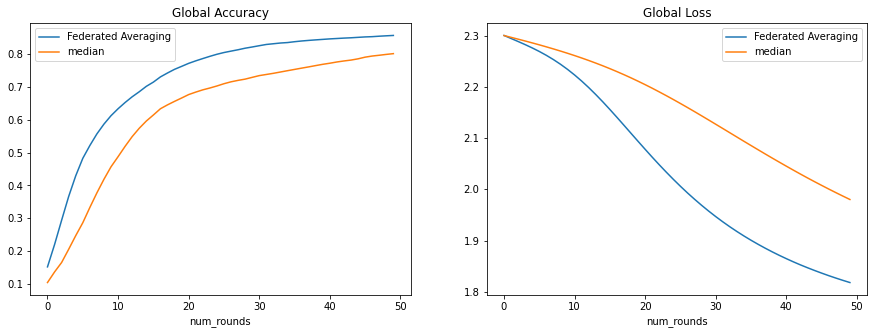

In [85]:

rounds = np.linspace(0, 49, 50)

fig, ax = plt.subplots(1,2, figsize = (15, 5))
ax[0].plot(rounds, Global_Accuracy_fa, label = 'Federated Averaging')
ax[0].plot(rounds, Global_Accuracy_med, label = 'median')
ax[0].set_title('Global Accuracy')
ax[0].set_xlabel('num_rounds')
ax[0].legend()
ax[1].plot(rounds, Global_LOSS_fa, label = 'Federated Averaging')
ax[1].plot(rounds, Global_LOSS_med, label = 'median')
ax[1].set_title('Global Loss')
ax[1].set_xlabel('num_rounds')
ax[1].legend()
#plt.show()
plt.savefig('alpha05', dpi = 500, pad_inches = 0.1, bbox_inches='tight')

With alpha = 0.05, the average seems to still perform better than median, with a faster convergence trend and steeper slope for loss. However, One-round robust median method is able to outperform the averaging method with a shorter execution time.

### alpha = 0.1

In [8]:
clients = create_clients(x_train_flattened, y_train, num_clients=20, initial='client')

In [9]:
#choose client1 as byzantine machine for alpha = 0.05

corrupted_values1 = list()
for i in clients['client_1']:
    new_values = [0,0,0,0,0,0,0,0,0,0]
    for v in range(len(i[1])):
        if i[1][v]==1:
            curr_label = v
            corrupted_label = v-8
            if corrupted_label < 0:
                corrupted_label = curr_label+2
            new_values[corrupted_label] = 1
    corrupted_values1.append([i[0], new_values])

corrupted_values2 = list()
for i in clients['client_2']:
    new_values = [0,0,0,0,0,0,0,0,0,0]
    for v in range(len(i[1])):
        if i[1][v]==1:
            curr_label = v
            corrupted_label = v-8
            if corrupted_label < 0:
                corrupted_label = curr_label+2
            new_values[corrupted_label] = 1
    corrupted_values2.append([i[0], new_values])


In [10]:
corrupted_clients = clients
corrupted_clients.update({'client_1': corrupted_values1})
corrupted_clients.update({'client_2': corrupted_values2})

In [11]:
corrupted_clients_batched = dict()
for (client_name, data) in corrupted_clients.items():
    corrupted_clients_batched[client_name] = batch_data(data)

#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((x_test_flattened, y_test)).batch(len(y_test))

In [12]:
comms_round = 50

#### Fed Averaging

In [14]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
        
Global_Accuracy_fa = list()
Global_LOSS_fa = list()
    
#commence global training loop
for comm_round in range(comms_round):
            
    
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(corrupted_clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_fa.append(global_acc)
    Global_LOSS_fa.append(global_loss)
    

comm_round: 0 | global_acc: 74.510% | global_loss: 2.1393585205078125
comm_round: 1 | global_acc: 83.020% | global_loss: 1.9002712965011597
comm_round: 2 | global_acc: 85.530% | global_loss: 1.796875
comm_round: 3 | global_acc: 86.750% | global_loss: 1.7489500045776367
comm_round: 4 | global_acc: 87.640% | global_loss: 1.7214429378509521
comm_round: 5 | global_acc: 88.290% | global_loss: 1.7043983936309814
comm_round: 6 | global_acc: 88.660% | global_loss: 1.6925601959228516
comm_round: 7 | global_acc: 89.240% | global_loss: 1.6838152408599854
comm_round: 8 | global_acc: 89.520% | global_loss: 1.677018165588379
comm_round: 9 | global_acc: 89.650% | global_loss: 1.6721484661102295
comm_round: 10 | global_acc: 89.850% | global_loss: 1.6678497791290283
comm_round: 11 | global_acc: 89.970% | global_loss: 1.6642882823944092
comm_round: 12 | global_acc: 90.140% | global_loss: 1.661464810371399
comm_round: 13 | global_acc: 90.290% | global_loss: 1.659173607826233
comm_round: 14 | global_acc: 

#### Median

In [15]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

Global_Accuracy_med = list()
Global_LOSS_med = list()

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=1, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)

    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_med.append(global_acc)
    Global_LOSS_med.append(global_loss)

comm_round: 0 | global_acc: 31.390% | global_loss: 2.2850847244262695
comm_round: 1 | global_acc: 54.820% | global_loss: 2.257404327392578
comm_round: 2 | global_acc: 64.250% | global_loss: 2.2190592288970947
comm_round: 3 | global_acc: 69.350% | global_loss: 2.168937921524048
comm_round: 4 | global_acc: 73.340% | global_loss: 2.111124277114868
comm_round: 5 | global_acc: 76.670% | global_loss: 2.0520339012145996
comm_round: 6 | global_acc: 79.090% | global_loss: 1.9969050884246826
comm_round: 7 | global_acc: 81.040% | global_loss: 1.9490379095077515
comm_round: 8 | global_acc: 82.420% | global_loss: 1.908787727355957
comm_round: 9 | global_acc: 83.640% | global_loss: 1.8750144243240356
comm_round: 10 | global_acc: 84.570% | global_loss: 1.8467469215393066
comm_round: 11 | global_acc: 85.240% | global_loss: 1.823076605796814
comm_round: 12 | global_acc: 85.790% | global_loss: 1.8030632734298706
comm_round: 13 | global_acc: 86.160% | global_loss: 1.786032795906067
comm_round: 14 | globa

#### One Round Robust Median

In [16]:
comms_round = 1

In [17]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)


#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=100, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)

    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)


comm_round: 0 | global_acc: 90.440% | global_loss: 1.6284579038619995


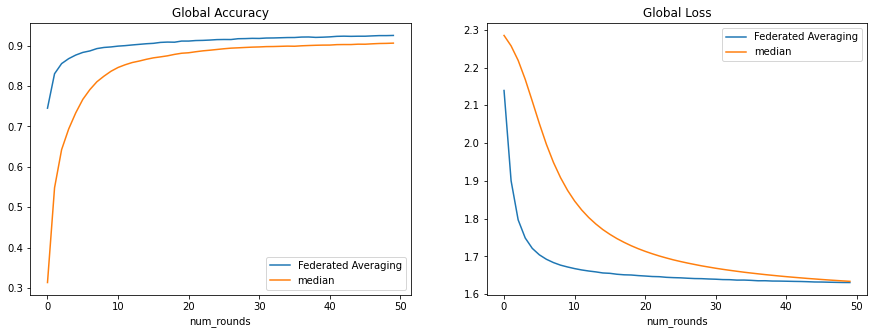

In [18]:
rounds = np.linspace(0, 49, 50)

fig, ax = plt.subplots(1,2, figsize = (15, 5))
ax[0].plot(rounds, Global_Accuracy_fa, label = 'Federated Averaging')
ax[0].plot(rounds, Global_Accuracy_med, label = 'median')
ax[0].set_title('Global Accuracy')
ax[0].set_xlabel('num_rounds')
ax[0].legend()
ax[1].plot(rounds, Global_LOSS_fa, label = 'Federated Averaging')
ax[1].plot(rounds, Global_LOSS_med, label = 'median')
ax[1].set_title('Global Loss')
ax[1].set_xlabel('num_rounds')
ax[1].legend()
#plt.show()
plt.savefig('alpha01', dpi = 500, pad_inches = 0.1, bbox_inches='tight')

I think there is something wrong going on with this set of settings. Might be due to tensorflow not clearing the cache. Will have to be ware of this situation in the future.

### alpha = 0.15

In [19]:
clients = create_clients(x_train_flattened, y_train, num_clients=20, initial='client')

In [20]:
#choose client1 as byzantine machine for alpha = 0.05

corrupted_values1 = list()
for i in clients['client_1']:
    new_values = [0,0,0,0,0,0,0,0,0,0]
    for v in range(len(i[1])):
        if i[1][v]==1:
            curr_label = v
            corrupted_label = v-8
            if corrupted_label < 0:
                corrupted_label = curr_label+2
            new_values[corrupted_label] = 1
    corrupted_values1.append([i[0], new_values])

corrupted_values2 = list()
for i in clients['client_2']:
    new_values = [0,0,0,0,0,0,0,0,0,0]
    for v in range(len(i[1])):
        if i[1][v]==1:
            curr_label = v
            corrupted_label = v-8
            if corrupted_label < 0:
                corrupted_label = curr_label+2
            new_values[corrupted_label] = 1
    corrupted_values2.append([i[0], new_values])

corrupted_values3 = list()
for i in clients['client_3']:
    new_values = [0,0,0,0,0,0,0,0,0,0]
    for v in range(len(i[1])):
        if i[1][v]==1:
            curr_label = v
            corrupted_label = v-8
            if corrupted_label < 0:
                corrupted_label = curr_label+2
            new_values[corrupted_label] = 1
    corrupted_values3.append([i[0], new_values])

In [21]:
corrupted_clients = clients
corrupted_clients.update({'client_1': corrupted_values1})
corrupted_clients.update({'client_2': corrupted_values2})
corrupted_clients.update({'client_3': corrupted_values3})

In [22]:
corrupted_clients_batched = dict()
for (client_name, data) in corrupted_clients.items():
    corrupted_clients_batched[client_name] = batch_data(data)

#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((x_test_flattened, y_test)).batch(len(y_test))

In [23]:
comms_round = 50

#### Fed Averaging

In [24]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
        
Global_Accuracy_fa = list()
Global_LOSS_fa = list()
    
#commence global training loop
for comm_round in range(comms_round):
            
    
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(corrupted_clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_fa.append(global_acc)
    Global_LOSS_fa.append(global_loss)
    

comm_round: 0 | global_acc: 10.370% | global_loss: 2.299567222595215
comm_round: 1 | global_acc: 15.540% | global_loss: 2.2947003841400146
comm_round: 2 | global_acc: 21.300% | global_loss: 2.289745330810547
comm_round: 3 | global_acc: 27.580% | global_loss: 2.284576654434204
comm_round: 4 | global_acc: 34.540% | global_loss: 2.2791054248809814
comm_round: 5 | global_acc: 42.250% | global_loss: 2.2732434272766113
comm_round: 6 | global_acc: 49.090% | global_loss: 2.2669265270233154
comm_round: 7 | global_acc: 54.540% | global_loss: 2.26009202003479
comm_round: 8 | global_acc: 58.520% | global_loss: 2.252699851989746
comm_round: 9 | global_acc: 61.620% | global_loss: 2.244685411453247
comm_round: 10 | global_acc: 63.850% | global_loss: 2.2360565662384033
comm_round: 11 | global_acc: 65.920% | global_loss: 2.226785182952881
comm_round: 12 | global_acc: 67.320% | global_loss: 2.216871976852417
comm_round: 13 | global_acc: 69.000% | global_loss: 2.206387519836426
comm_round: 14 | global_ac

#### Median

In [25]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

Global_Accuracy_med = list()
Global_LOSS_med = list()

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=1, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)

    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    Global_Accuracy_med.append(global_acc)
    Global_LOSS_med.append(global_loss)

comm_round: 0 | global_acc: 19.630% | global_loss: 2.2966387271881104
comm_round: 1 | global_acc: 25.810% | global_loss: 2.2912819385528564
comm_round: 2 | global_acc: 32.060% | global_loss: 2.2857916355133057
comm_round: 3 | global_acc: 38.680% | global_loss: 2.2800097465515137
comm_round: 4 | global_acc: 44.580% | global_loss: 2.2738747596740723
comm_round: 5 | global_acc: 49.630% | global_loss: 2.267244577407837
comm_round: 6 | global_acc: 53.990% | global_loss: 2.2600855827331543
comm_round: 7 | global_acc: 57.040% | global_loss: 2.2523140907287598
comm_round: 8 | global_acc: 59.910% | global_loss: 2.2438743114471436
comm_round: 9 | global_acc: 62.280% | global_loss: 2.2347421646118164
comm_round: 10 | global_acc: 64.160% | global_loss: 2.2249019145965576
comm_round: 11 | global_acc: 65.810% | global_loss: 2.214305877685547
comm_round: 12 | global_acc: 67.130% | global_loss: 2.2029733657836914
comm_round: 13 | global_acc: 68.300% | global_loss: 2.1909191608428955
comm_round: 14 | g

#### One Round Robust Median

In [26]:
comms_round = 1

In [27]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)


#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(corrupted_clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(corrupted_clients_batched[client], epochs=100, verbose=0)
        local_weight_list.append(local_model.get_weights())
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the median over all the local model, we simply take the sum of the scaled weights
    medium_weight = get_median(local_weight_list)

    #update global model 
    global_model.set_weights(medium_weight)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)


comm_round: 0 | global_acc: 88.040% | global_loss: 1.721895694732666


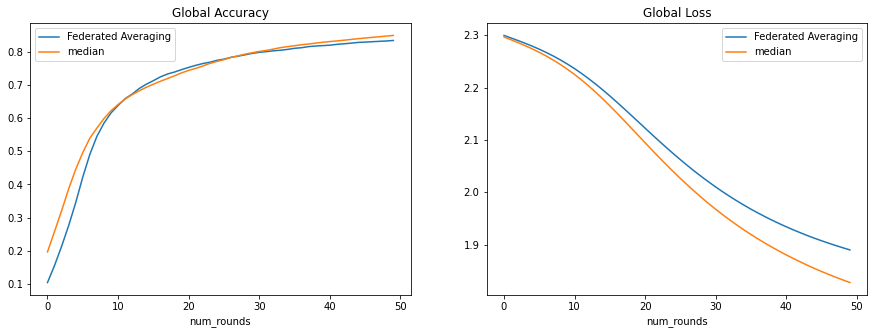

In [29]:
rounds = np.linspace(0, 49, 50)

fig, ax = plt.subplots(1,2, figsize = (15, 5))
ax[0].plot(rounds, Global_Accuracy_fa, label = 'Federated Averaging')
ax[0].plot(rounds, Global_Accuracy_med, label = 'median')
ax[0].set_title('Global Accuracy')
ax[0].set_xlabel('num_rounds')
ax[0].legend()
ax[1].plot(rounds, Global_LOSS_fa, label = 'Federated Averaging')
ax[1].plot(rounds, Global_LOSS_med, label = 'median')
ax[1].set_title('Global Loss')
ax[1].set_xlabel('num_rounds')
ax[1].legend()
#plt.show()
plt.savefig('alpha15', dpi = 500, pad_inches = 0.1, bbox_inches='tight')

In alpha = 0.15 setting, Median and One-round median both outperforms the averaging method. I think it is becaUse as the fraction of byzantine machines increase, the averaging method is also perform worse due to the nature of mean. Whereas median is more stable against outliers.

## Topic 3: Deep Leakage from Gradients

Under Federated Learning setting, it’s possible to retrieve original user data if the malicious attackers can gain access to the history of gradients of the targeted user. The attacker can optimize the distance between the gradient of its dummy weights and the gradients of the target user to recover the original data. In this topic, we are experimenting with CIFAR-100 dataset using the algorithm proposed by  L. Zhu et al. https://arxiv.org/abs/1906.08935

The following codes and model setup is adopted from the same article mentioned above and its related GitHub  https://github.com/mit-han-lab/dlg


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
print(torch.__version__, torchvision.__version__)

1.8.1 0.9.1


In [2]:
device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
print("Running on %s" % device)

Running on cpu


Download dataset from torch. https://pytorch.org/vision/stable/datasets.html#cifar

In [4]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

Files already downloaded and verified


Each colored image is stored in numpy array with dimension [1,3,32,32] The data is passed into tensor and labels are one-hot encoded before passing into the algorithm

In [5]:
img_index = 15
gt_data = tp(dst[img_index][0]).to(device)

In [6]:
gt_data = gt_data.view(1, *gt_data.size())

In [7]:
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)

In [8]:
gt_data.shape

torch.Size([1, 3, 32, 32])

An example of the CIFAR image

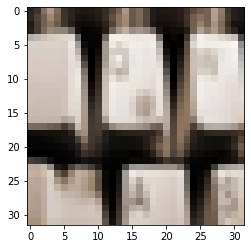

In [9]:
plt.imshow(tt(gt_data[0].cpu()))

Inital Weights and LeNet-5 is set accordingly based on the L.Zhu et al's algorithm demo

In [10]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out


In [11]:
net = LeNet().to(device)

In [12]:
torch.manual_seed(1234)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

Compute gradients for one particular user data

In [13]:
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

In [14]:
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

initializing dummy data

In [15]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

An example of dummy data

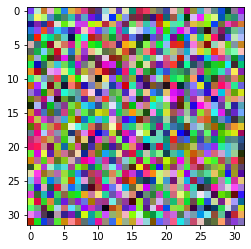

In [16]:
plt.imshow(tt(dummy_data[0].cpu()))

Optimizer is et to LBFGS with default settings

In [17]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

An example run of the algorithm

In [18]:
history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))

0 102.7582
10 1.4926
20 0.1586
30 0.0286
40 0.0069
50 0.0022
60 0.0009
70 0.0004
80 0.0002
90 0.0001
100 0.0001
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000


The convergence progress for every 10 iterations

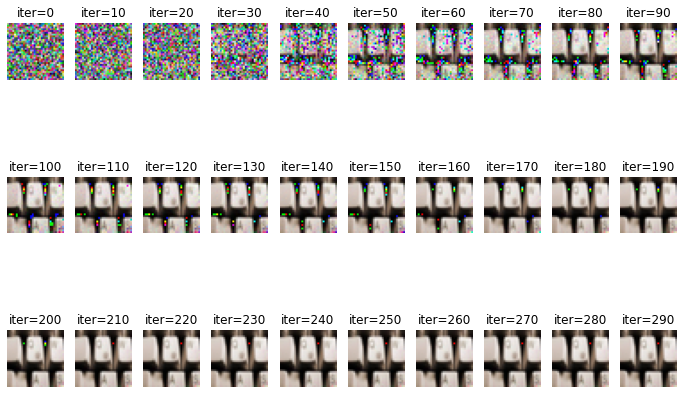

In [19]:
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.show()

Repeat the algorithm for 10 times to test if the convergence is consistent

0 898.5670
20 740.4523
40 716.9922
60 696.4415
80 679.5613
100 667.9937
120 658.5922
140 628.7174
160 618.7570
180 612.8718
200 608.1757
220 604.2855
240 601.9611
260 600.0963
280 598.7280


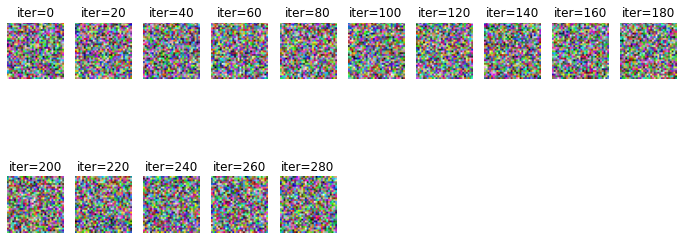

0 42.8739
20 0.0588
40 0.0052
60 0.0009
80 0.0003
100 0.0001
120 0.0000
140 0.0000
160 0.0000
180 0.0000
200 0.0000
220 0.0000
240 0.0000
260 0.0000
280 0.0000


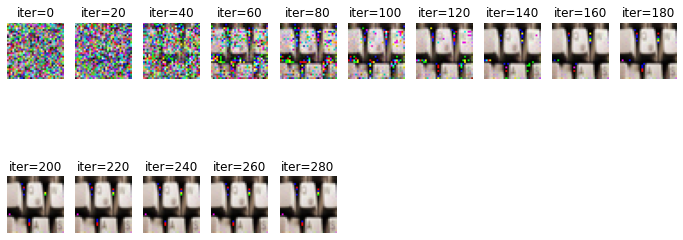

0 75.6452
20 0.1843
40 0.0049
60 0.0004
80 0.0001
100 0.0000
120 0.0000
140 0.0000
160 0.0000
180 0.0000
200 0.0000
220 0.0000
240 0.0000
260 0.0000
280 0.0000


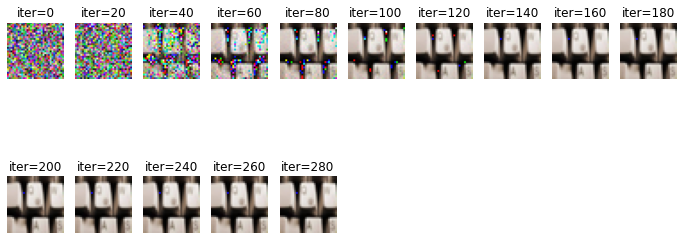

0 82.9248
20 0.0909
40 0.0072
60 0.0011
80 0.0003
100 0.0001
120 0.0000
140 0.0000
160 0.0000
180 0.0000
200 0.0000
220 0.0000
240 0.0000
260 0.0000
280 0.0000


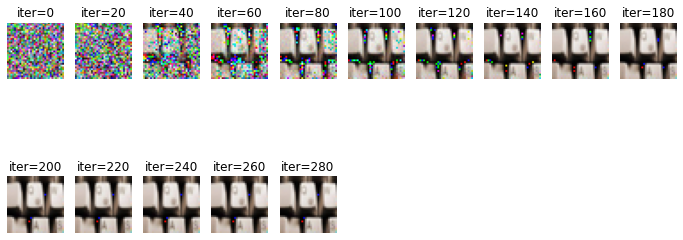

0 305.6954
20 565.8298
40 565.8298
60 565.8298
80 565.8298
100 565.8298
120 565.8298
140 565.8298
160 565.8298
180 565.8298
200 565.8298
220 565.8298
240 565.8298
260 565.8298
280 565.8298


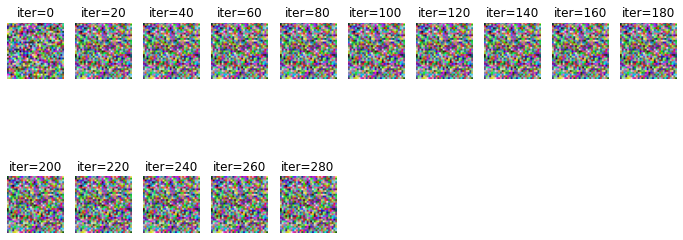

0 211.3147
20 60.9621
40 30.6292
60 20.9806
80 17.8637
100 15.8545
120 14.5057
140 13.5734
160 12.6739
180 12.0667
200 11.6537
220 11.3018
240 11.0451
260 10.7009
280 10.3815


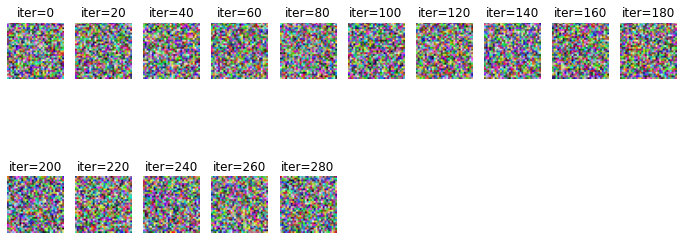

0 130.0322
20 0.3216
40 0.0154
60 0.0022
80 0.0005
100 0.0001
120 0.0000
140 0.0000
160 0.0000
180 0.0000
200 0.0000
220 0.0000
240 0.0000
260 0.0000
280 0.0000


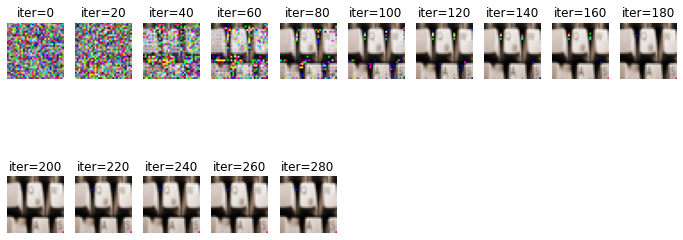

0 947.8541
20 1168.5184
40 1168.5184
60 1168.5184
80 1168.5184
100 1168.5184
120 1168.5184
140 1168.5184
160 1168.5184
180 1168.5184
200 1168.5184
220 1168.5184
240 1168.5184
260 1168.5184
280 1168.5184


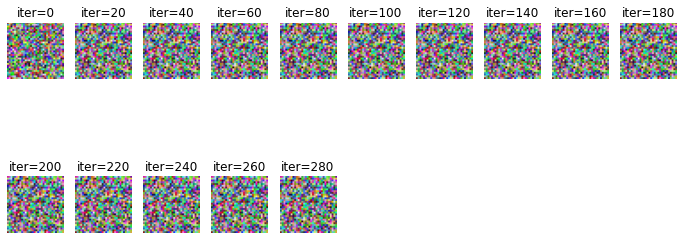

0 102.8998
20 0.5239
40 0.0488
60 0.0062
80 0.0015
100 0.0004
120 0.0001
140 0.0000
160 0.0000
180 0.0000
200 0.0000
220 0.0000
240 0.0000
260 0.0000
280 0.0000


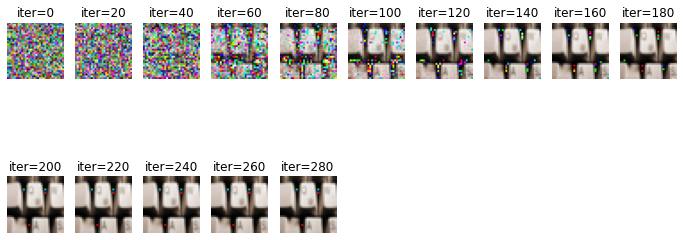

0 84.1866
20 0.5253
40 0.0224
60 0.0025
80 0.0004
100 0.0001
120 0.0000
140 0.0000
160 0.0000
180 0.0000
200 0.0000
220 0.0000
240 0.0000
260 0.0000
280 0.0000


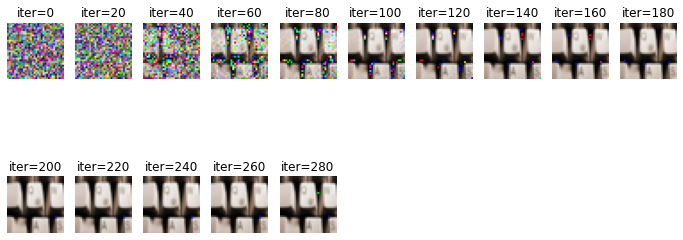

In [21]:
for trial in range(10):
    
    net = LeNet().to(device)
    #torch.manual_seed(1234)

    net.apply(weights_init)
    criterion = cross_entropy_for_onehot
    
    pred = net(gt_data)
    y = criterion(pred, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())
    
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    
    
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
    
    history = []
    for iters in range(300):
        def closure():
            optimizer.zero_grad()

            dummy_pred = net(dummy_data) 
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()

            return grad_diff
        
        
        optimizer.step(closure)
        
        
        
        if iters % 20 == 0: 
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
            history.append(tt(dummy_data[0].cpu()))
        

    plt.figure(figsize=(12, 8))
    for i in range(15):
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[i])
        plt.title("iter=%d" % (i * 20))
        plt.axis('off')

    plt.show()

In some cases the algorithm failed to converge. It can possibly come from these three area:
1. the weights or gradients didnt clear during each re-run
2. the network isn't suited for this particular setup
3. the initial guesses ended up too near a local minimum

# Conclusion

Federated Learning is capable of achieving similar performance to centralized learning under simulated condition (No byzantine machines). This opens up a door for traditional machine learning methods to be implemented in the decentralized settings. In many cases where the data privacy is important, this approach might be the best of both world-- high accuracy and less privacy intrusion. 


In the presence of Byzantine machines, Pairwise median approach and One-shot median approach can potentially improve model accuracy over the conventionaly averaging methods to have a more robust result. These approaches might have a real world applications where people don't always get the best information from decentralized network.

What to keep in mind is that gradient leakage can potential cause privacy breach if the malicious attacker is able to gain information about original data’s dimension and have a good initial guess with an appropriate model setup. There could be some extra security measures on top of conventional federated learning model to prevent such leak.


# References

1. Gafni, Tomer, et al. “Federated Learning: A Signal Processing Perspective”, arXiv preprint arXiv:2103.17150
(2021).
2. T. Li, A. K. Sahu, A. Talwalkar and V. Smith, “Federated Learning: Challenges, Methods, and Future Directions”, in IEEE Signal Processing Magazine, vol. 37, no. 3, pp. 50-60, May 2020, doi: 10.1109/MSP.2020.2975749.
3. Yin, Dong, Yudong Chen,Kannan Ramchandran and Peter Bartlett. “Byzantine-robust distributed learning:
Towards optimal statistical rates”, International Conference on Machine Learning. PMLR, 2018.
4. L. Zhu, Z. Liu, and S. Han, “Deep leakage from gradients”, in Advances in Neural Information Processing
Systems, H. Wallach, H. Larochelle, A. Beygelzimer, F. d’Alch-Buc, E. Fox,and R. Garnett, Eds., vol.
32.Curran Associates, Inc., 2019.